# Exercise 1: Classifying penguin species with PyTorch

<img src="https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png" width="750" />


Artwork by @allison_horst

In this exercise, we will use the python package [``palmerpenguins``](https://github.com/mcnakhaee/palmerpenguins) to supply a toy dataset containing various features and measurements of penguins.

We have already created a PyTorch dataset which yields data for each of the penguins, but first we should examine the dataset and see what it contains.

### Task 1: look at the data
In the following code block, we import the ``load_penguins`` function from the ``palmerpenguins`` package.

- Call this function, which returns a single object, and assign it to the variable ``data``.
  - Print ``data`` and recognise that ``load_penguins`` has returned a ``pandas.DataFrame``.
- Consider which features it might make sense to use in order to classify the species of the penguins.
  - You can print the column titles using ``pd.DataFrame.keys()``
  - You can also obtain useful information using ``pd.DataFrame.Series.describe()``

In [41]:
from palmerpenguins import load_penguins

data = load_penguins()

# Note: ``pd.DataFrame.describe`` is a useful function for giving an overview
# of what a ``pd.DataFrame`` contains.
print(data.describe())

print(data.keys())

print(data["species"].value_counts(dropna=True))

data.head()

       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
count      342.000000     342.000000         342.000000   342.000000   
mean        43.921930      17.151170         200.915205  4201.754386   
std          5.459584       1.974793          14.061714   801.954536   
min         32.100000      13.100000         172.000000  2700.000000   
25%         39.225000      15.600000         190.000000  3550.000000   
50%         44.450000      17.300000         197.000000  4050.000000   
75%         48.500000      18.700000         213.000000  4750.000000   
max         59.600000      21.500000         231.000000  6300.000000   

              year  
count   344.000000  
mean   2008.029070  
std       0.818356  
min    2007.000000  
25%    2007.000000  
50%    2008.000000  
75%    2009.000000  
max    2009.000000  
Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')
species
Adelie    

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Let's now discuss the features we will use to classify the penguins' species, and populate the following list together:

#### Let's use:

- ``"bill_length_mm"``
    - Biologically relevant and unambiguous.
- ``"bill_depth_mm"``
    - Biologically relevant.
- ``flipper_length_mm``
    - Biologically relevant.
- ``"body_mass_g"``
    - Biologically relevant.
- ``"sex"``
    - While a potential source of bias, it is likely informative and biologically relevant.

#### Let's reject
- ``"island"``
    - While island is likely to be predictive, it seems potentially misleading to use this feature. One island could be heavily dominated by one species of penguin, while other species abide there in much smaller numbers. Such a situation could result in a model giving too much weight to this feature, and confounding the results.
- ``"year"``
    - This feature could also be important: then behaviour of certain species may be changing in response to time-dependent environmental factors such as melting ice. It does however seem like the least biologically-relevant feature, and the most likely source of bias, so we reject it.

### Task 2: creating a ``torch.utils.data.Dataset``

The penguin data reading and processing can be encapsulated in a PyTorch dataset class.

- Why is a class representation helpful?
  - Modularity - Separation of concerns makes the code easier to understand, maintain and test.
  - Maintainability - Changes are localised, therefore we only need to change a single file to update. 
  - Abstraction - Users do not need to know how the data is read or processed, they only need to know how to interact with the class. 

All PyTorch dataset objects are subclasses of the ``torch.utils.data.Dataset`` class. To make a custom dataset, create a class which inherits from the ``Dataset`` class, implement some methods (the Python magic (or dunder) methods ``__len__`` and ``__getitem__``) and supply some data.

Spoiler alert: we've done this for you already below (see ``src/ml_workshop/_penguins.py`` for a more sophisticated implementation)

- Open the file ``src/ml_workshop/_penguins.py``.
- Let's examine, and discuss, each of the methods together.
  - ``__len__``
    - What does the ``__len__`` method do?
      - The ``__len__`` method is a so-called "magic method", which tells python to do if the ``len`` function is called on the object containing it.
  - ``__getitem__``
    - What does the ``__getitem__`` method do?
      - The ``__getitem__`` method is another magic method which tells python what to do if we try and index the object containing it (i.e. ``my_object[idx]``).
- Review and discuss the class arguments.
  - ``input_keys``— A sequence of strings telling the data set which objects to return as inputs to the model.
  - ``target_keys``— Same as ``input_keys`` but specifying the targets.
  - ``train``— A boolean variable determining if the model returns the training or validation split (``True`` for training).

In [42]:
from typing import List, Tuple, Dict

# import some useful functions here, see https://pytorch.org/docs/stable/torch.html
# where `tensor` is used for constructing tensors,
# and using a lower-precision float32 is advised for performance

# Task 4: add imports here
from torch import tensor, Tensor, float32, long

from torch.utils.data import Dataset

from palmerpenguins import load_penguins


class PenguinDataset(Dataset):
    """Simplified Penguin dataset for classification tasks.

    Parameters
    ----------
    input_keys : List[str]
        Column names to use as input features.
    target_key : str
        Categorical target column (e.g., "species").
    train : bool
        If ``True``, this object will serve as the training set, and if
        ``False``, the validation set.

    Notes
    -----
    The validation split contains 10 male and 10 female penguins of each
    species.
    """
    def __init__(
        self,
        input_keys: List[str],
        target_key: str,
        train: bool,
    ):
        """Build `PenguinDataset` for classification."""
        self.input_keys = input_keys
        self.target_key = target_key

        # Load and clean full dataset
        data = load_penguins()
        data = (
            data.dropna()
            .sort_values(by=sorted(data.columns))
            .reset_index(drop=True)
        )
        data["sex"] = (data["sex"] == "male").astype(float)
        self.full_df = data

        # Create stratified validation split
        valid_df = data.groupby(["species", "sex"]).sample(n=10, random_state=123)
        train_df = data[~data.index.isin(valid_df.index)]

        # Choose split
        split_df = train_df if train else valid_df

        # Build label map from the full dataset
        unique_labels = sorted(self.full_df[target_key].unique())
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}

        # Precompute tensors from split only
        self.features = tensor(split_df[input_keys].values, dtype=float32)
        self.targets = tensor(
            split_df[target_key].map(self.label_map).values,
            dtype=long
        )

    def get_label_map(self) -> Dict:
        """Return the label-to-index mapping."""
        return self.label_map

    def __len__(self) -> int:
        """Return the length of requested split.

        Returns
        -------
        int
            The number of items in the dataset.

        """
        # Task 4 - Exercise #1: Return length of features
        return len(self.features)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        """Return an input-target pair.

        Parameters
        ----------
        idx : int
            Index of the input-target pair to return.

        Returns
        -------
        in_feats : Tensor
            Inputs.
        target : Tensor
            Targets.

        """
        # Task 4 - Exercise #2: Return example
        return self.features[idx], self.targets[idx]

### Task 3: obtaining training and validation datasets

- Instantiate the penguin dataloader.
  - Make sure you supply the correct column titles for the features and the targets.
- Then iterate over the dataset

In [45]:
features = [
    "bill_length_mm",
    "bill_depth_mm",
    "body_mass_g",
    "flipper_length_mm",
    "sex",
]

target_names = sorted(data.species.unique())

data_set = PenguinDataset(
    input_keys=features,
    target_key="species",
    train=True,
)

for _, (input_feats, target) in zip(range(20), data_set):
    print(input_feats, target)

tensor([  42.9000,   13.1000, 5000.0000,  215.0000,    0.0000]) tensor(2)
tensor([  46.1000,   13.2000, 4500.0000,  211.0000,    0.0000]) tensor(2)
tensor([  44.9000,   13.3000, 5100.0000,  213.0000,    0.0000]) tensor(2)
tensor([  43.3000,   13.4000, 4400.0000,  209.0000,    0.0000]) tensor(2)
tensor([  42.0000,   13.5000, 4150.0000,  210.0000,    0.0000]) tensor(2)
tensor([  46.5000,   13.5000, 4550.0000,  210.0000,    0.0000]) tensor(2)
tensor([  44.0000,   13.6000, 4350.0000,  208.0000,    0.0000]) tensor(2)
tensor([  40.9000,   13.7000, 4650.0000,  214.0000,    0.0000]) tensor(2)
tensor([  42.6000,   13.7000, 4950.0000,  213.0000,    0.0000]) tensor(2)
tensor([  42.7000,   13.7000, 3950.0000,  208.0000,    0.0000]) tensor(2)
tensor([  45.3000,   13.7000, 4300.0000,  210.0000,    0.0000]) tensor(2)
tensor([  47.2000,   13.7000, 4925.0000,  214.0000,    0.0000]) tensor(2)
tensor([  45.2000,   13.8000, 4750.0000,  215.0000,    0.0000]) tensor(2)
tensor([  43.6000,   13.9000, 4900.000

* Can we give these items to a neural network, or do they need to be transformed first?
  + Short answer: no, we can't just pass tuples of numbers or strings to a neural network.
    - We must represent these data as ``torch.Tensor``s. This is the fundamental data abstraction used by PyTorch; they are the PyTorch equivalent to Numpy arrays. See [pytorch tensors documentation](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html) . 
    - The targets are tuples of strings i.e. ('Gentoo', )
      - One idea is to represent as ordinal values i.e.  [1] or [2] or [3]. Will this work? 

### Task 4: Applying transforms to the data

Modify the `PenguinDataset` class above so that the tuples of numbers are converted to PyTorch `torch.Tensor` s and the string targets are converted to one-hot vectors.

- Begin by importing relevant PyTorch functions.
- Apply transformations inside `__getitem__()` function above.

Then create a training and validation set.

  - We allow the model to learn directly from the training set—i.e. we fit the function to these data.
  - During training, we monitor the model's performance on the validation set in order to check how it's doing on unseen data. Normally, people use the validation performance to determine when to stop the training process.
  
For the validation set, we choose ten males and ten females of each species. This means the validation set is less likely to be biased by sex and species, and is potentially a more reliable measure of performance. You should always be _very_ careful when choosing metrics and splitting data.

- Is this solution general?
  - No. The transformations have been hardcoded. A more flexible way of transforming inputs to neural networks is to apply a series of transforms using `torchvision.transforms.Compose`. The [ `Compose` ](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html) object takes a list of callable objects and applies them to the incoming data. See how this is done more generally in the `src/ml_workshop/_penguins.py` file. 

These transforms can be very useful for mapping between file paths and tensors of images, etc.

In [46]:
# Apply transforms we need to PenguinDataset to convert input data and target class to tensors.
# See Task 4 exercise comments above.


# Create train_set
train_set = PenguinDataset(
    input_keys=features,
    target_key="species",
    train=True,
)

# Create valid_set
valid_set = PenguinDataset(
    input_keys=features,
    target_key="species",
    train=False,
)


for _, (input_feats, target) in zip(range(5), train_set):
    print(input_feats, target)

tensor([  42.9000,   13.1000, 5000.0000,  215.0000,    0.0000]) tensor(2)
tensor([  46.1000,   13.2000, 4500.0000,  211.0000,    0.0000]) tensor(2)
tensor([  44.9000,   13.3000, 5100.0000,  213.0000,    0.0000]) tensor(2)
tensor([  43.3000,   13.4000, 4400.0000,  209.0000,    0.0000]) tensor(2)
tensor([  42.0000,   13.5000, 4150.0000,  210.0000,    0.0000]) tensor(2)


### (Optional) Task 4b: 

Apply the `torchvision.transforms.Compose` transformations instead of hardcoding as above. 

In [ ]:
from torchvision.transforms import Compose

from ml_workshop import PenguinDataset

# import some useful functions here, see https://pytorch.org/docs/stable/torch.html
# where `tensor` and `eye` are used for constructing tensors,
# and using a lower-precision float32 is advised for performance
from torch import tensor, float32, long


# Apply the transforms we need to the PenguinDataset to get out input
# targets as Tensors.


def get_input_transforms() -> Compose:
    """Return transforms which map from raw inputs to tensors.

    Returns
    -------
    Compose
        A composition of transforms (callable functions) to map the tuple
        of input features (``Tuple[float, ...]``) to a ``torch.Tensor``.

    Notes
    -----
    To create a ``torch.Tensor`` we can use ``torch.tensor([1.0, 2.0, ...])``

    """
    return Compose([lambda x: tensor(x, dtype=float32)])


def get_target_tfms() -> Compose:
    """Return transforms which map from the raw target strings to tensor.

    Returns
    -------
    Compose
        A composition of transforms (callable functions) to map the tuple
        of input features (``Tuple[str]``) to a ``torch.Tensor``.
    """
    return Compose([lambda x: tensor(target_names.index(x[0]), dtype=long)])


train_set = PenguinDataset(
    input_keys=features,
    target_keys=["species"],
    train=True,
    x_tfms=get_input_transforms(),
    y_tfms=get_target_tfms(),
)


valid_set = PenguinDataset(
    input_keys=features,
    target_keys=["species"],
    train=False,
    x_tfms=get_input_transforms(),
    y_tfms=get_target_tfms(),
)


for _, (input_feats, target) in zip(range(5), train_set):
    print(input_feats, target)

tensor([  42.9000,   13.1000, 5000.0000,  215.0000,    0.0000]) tensor(2)
tensor([  46.1000,   13.2000, 4500.0000,  211.0000,    0.0000]) tensor(2)
tensor([  44.9000,   13.3000, 5100.0000,  213.0000,    0.0000]) tensor(2)
tensor([  43.3000,   13.4000, 4400.0000,  209.0000,    0.0000]) tensor(2)
tensor([  42.0000,   13.5000, 4150.0000,  210.0000,    0.0000]) tensor(2)


### Task 5: Creating ``DataLoaders``—and why

- Once we have created a ``Dataset`` object, we wrap it in a ``DataLoader``.
  - The ``DataLoader`` object allows us to put our inputs and targets in mini-batches, which makes for more efficient training.
    - Note: rather than supplying one input-target pair to the model at a time, we supply "mini-batches" of these data at once (typically a small power of 2, like 16 or 32).
    - The number of items we supply at once is called the batch size.
  - The ``DataLoader`` can also randomly shuffle the data each epoch (when training).
  - It allows us to load different mini-batches in parallel, which can be very useful for larger datasets and images that can't all fit in memory at once.


Note: we are going to use batch normalisation layers in our network, which don't work if the batch size is one. This can happen on the last batch, if we don't choose a batch size that evenly divides the number of items in the data set. To avoid this, we can set the ``drop_last`` argument to ``True``. The last batch, which will be of size ``len(data_set) % batch_size`` gets dropped, and the data are reshuffled. This is only relevant during the training process - validation will use population statistics.

In [47]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

valid_loader = DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=False,
)

for batch, targets in valid_loader:
    print(batch.shape, targets.shape)

torch.Size([16, 5]) torch.Size([16])
torch.Size([16, 5]) torch.Size([16])
torch.Size([16, 5]) torch.Size([16])
torch.Size([12, 5]) torch.Size([12])


### Task 6: Creating a neural network in PyTorch

Here we will create our neural network in PyTorch, and have a general discussion on clean and messy ways of going about it.

- First, we will create quite an ugly network to highlight how to make a neural network in PyTorch on a very basic level.
- We will then discuss a trick for making the print-out nicer.
- Finally, we will discuss how the best approach would be to write a class where various parameters (e.g. number of layers, dropout probabilities, etc.) are passed as arguments.

In [48]:
from torch.nn import Module
from torch.nn import BatchNorm1d, Linear, LeakyReLU, Dropout, Sequential
from torch import Tensor


class FCNet(Module):
    """Fully-connected neural network.

    Parameters
    ----------
    in_feats : int
        The number of input features to the model.
    out_feats : int
        The number of output features (or classes) the model should produce.

    Notes
    -----
    The ``torch.nn.Sequential`` class allows us to "chain" multiple layers, rather
    than manually passing the output of one to the next in the forward
    function.

    """

    def __init__(self, in_feats: int, out_feats: int):
        """Build the neural network."""
        super().__init__()
        self._fwd_seq = Sequential(
            BatchNorm1d(in_feats),
            Linear(in_feats, 16),
            BatchNorm1d(16),
            Dropout(0.1),
            LeakyReLU(0.1),
            Linear(16, 16),
            BatchNorm1d(16),
            Dropout(0.1),
            LeakyReLU(0.1),
            Linear(16, out_feats),
        )

    def forward(self, batch: Tensor) -> Tensor:
        """Pass ``batch`` through the model.

        Parameters
        ----------
        batch : Tensor
            A mini-batch of inputs.

        Returns
        -------
        Tensor
            The result of passing ``batch`` through the model.

        """
        return self._fwd_seq(batch)


model = FCNet(len(features), len(target_names))
print(model)

FCNet(
  (_fwd_seq): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=16, bias=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Linear(in_features=16, out_features=16, bias=True)
    (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): LeakyReLU(negative_slope=0.1)
    (9): Linear(in_features=16, out_features=3, bias=True)
  )
)


### Task 7: Selecting a loss function

- Cross-entropy is about the most common loss function for classification.
  - Details on this loss function are available in the [PyTorch docs](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
- Let's instantiate it together.

In [49]:
from torch.nn import CrossEntropyLoss

loss_func = CrossEntropyLoss()

### Task 8: Selecting an optimiser

While we talked about stochastic gradient descent in the slides, most people use the so-called [Adam optimiser](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

You can think of it as a more complex and improved implementation of SGD.

In [50]:
# Create an optimiser and give it the model's parameters.
from torch.optim import Adam

optimiser = Adam(model.parameters())

### Task 9: Writing basic training and validation loops

- Before we jump in and write these loops, we must first choose an activation function to apply to the model's outputs.
  - Here we are going to use the softmax activation function: see [the PyTorch docs](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html).
  - For those of you who've studied physics, you may be remininded of the partition function in thermodynamics.
  - This activation function is good for classifcation when the result is one of ``A or B or C``.
    - It's bad if you even want to assign two classification to one images—say a photo of a dog _and_ a cat.
  - It turns the raw outputs, or logits, into "psuedo probabilities", and we take our prediction to be the most probable class.

- We will write the training loop together, then you can go ahead and write the (simpler) validation loop.

In [51]:
from typing import Dict, List

from numpy import mean

from torch import no_grad


def train_one_epoch(
    model: Module,
    train_loader: DataLoader,
    optimiser: Adam,
    loss_func: CrossEntropyLoss,
) -> Dict[str, float]:
    """Train ``model`` for once epoch.

    Parameters
    ----------
    model : Module
        The neural network.
    train_loader : DataLoader
        Training dataloader.
    optimiser : Adam
        The optimiser.
    loss_func : CrossEntropyLoss
        Cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.

    Notes
    -----
    - The ``model.train()`` is very important:
        - it turns on the dropout layers.
        - it tells the batch norm layers to use the incoming
          statistics, and let them contribute to their "memory".

    """
    model.train()
    metrics: Dict[str, List[float]] = {"loss": [], "accuracy": []}

    for batch, targets in train_loader:
        optimiser.zero_grad()

        preds = model(batch)

        loss = loss_func(preds, targets)

        loss.backward()

        optimiser.step()

        metrics["loss"].append(loss.item())
        metrics["accuracy"].append(batch_level_accuracy(preds, targets))

    return {key: float(mean(val)) for key, val in metrics.items()}


@no_grad()
def validate_one_epoch(
    model: Module,
    valid_loader: DataLoader,
    loss_func: CrossEntropyLoss,
) -> Dict[str, float]:
    """Validate ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        The neural network.
    valid_loader : DataLoader
        Training dataloader.
    loss_func : CrossEntropyLoss
        Cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        Metrics of interest.

    Notes
    -----
    - The ``model.eval()`` is also very important:
        - It turns off the dropout layers, which are likely to impair the
          validation performance and render it unrealistically poor.
        - It tells the batchnorm layers to _not_ use the batch's statistics,
          and to instead use the stats it has built up from the training set.
          The model should not "remember" anything from the validation set.
    - We also protect this function with ``torch.no_grad()``, because having
      gradients enabled while validating is a pointless waste of
      resources — they are only needed for training.

    """
    model.eval()
    metrics: Dict[str, List[float]] = {"loss": [], "accuracy": []}

    for batch, targets in valid_loader:
        # preds = model(batch).softmax(dim=1)
        preds = model(batch)

        loss = loss_func(preds, targets)

        metrics["loss"].append(loss.item())
        metrics["accuracy"].append(batch_level_accuracy(preds, targets))

    return {key: float(mean(val)) for key, val in metrics.items()}


@no_grad()
def batch_level_accuracy(preds: Tensor, targets: Tensor):
    """Compute the batch-level accuracy.

    Parameters
    ----------
    preds : Tensor
        The model's predictions.
    targets : Tensor
        The corresponding labels.

    Returns
    -------
    float
        The batch-level accuracy.

    Notes
    -----
    - This function assumes the ``preds`` have had the softmax
      applied to them along dimension 1, and that the predicted
      class is therefore ``preds.argmax(dim=1)``.

    """
    return (preds.argmax(dim=1) == targets).float().mean().item()

### Task 10: Training, extracting and plotting metrics

- Now we can train our model for a specified number of epochs.
  - During each epoch the model "sees" each training item once.
- Append the training and validation metrics to a list.
- Turn them into a ``pandas.DataFrame``
  - Note: You can turn a ``List[Dict{str, float}]``, say ``my_list`` into a ``DataFrame`` with ``DataFrame(my_list)``.
- Use Matplotlib to plot the training and validation metrics as a function of the number of epochs.

We will begin the code block together before you complete it independently.  
After some time we will go through the solution together.

In [52]:
from time import perf_counter

from pandas import DataFrame

epochs = 10
print_interval = 25


train_metrics, valid_metrics = [], []


for epoch in range(epochs):

    if epoch % print_interval == 0:
        if epoch != 0:
            print(
                f"Epoch {max(epoch - print_interval, 0)}-{epoch} time: {perf_counter() - tic:.6f} seconds"
            )
        tic = perf_counter()

    train_metrics.append(train_one_epoch(model, train_loader, optimiser, loss_func))

    valid_metrics.append(validate_one_epoch(model, valid_loader, loss_func))

    stop_time = perf_counter()


print("\n")

train_metrics = DataFrame(train_metrics)
valid_metrics = DataFrame(valid_metrics)

metrics = train_metrics.join(valid_metrics, lsuffix="_train", rsuffix="_valid")

print(metrics)

Epoch 0-25 time: 1.263641 seconds
Epoch 25-50 time: 0.760154 seconds
Epoch 50-75 time: 0.749647 seconds
Epoch 75-100 time: 0.751401 seconds
Epoch 100-125 time: 0.739841 seconds
Epoch 125-150 time: 0.738564 seconds
Epoch 150-175 time: 0.767019 seconds


     loss_train  accuracy_train  loss_valid  accuracy_valid
0      0.985093        0.610294    0.899907        0.687500
1      0.829953        0.779412    0.768794        0.703125
2      0.667880        0.845588    0.662767        0.781250
3      0.558345        0.908088    0.568255        0.812500
4      0.467251        0.930147    0.490484        0.890625
..          ...             ...         ...             ...
195    0.029514        0.992647    0.031024        0.984375
196    0.062836        0.974265    0.030409        0.984375
197    0.032623        0.992647    0.043078        0.984375
198    0.038023        0.985294    0.034589        0.984375
199    0.062603        0.977941    0.031661        0.984375

[200 rows x 4 columns]


### Task 11: Visualise some results

Let's do this part together—though feel free to make a start on your own if you have completed the previous exercises.

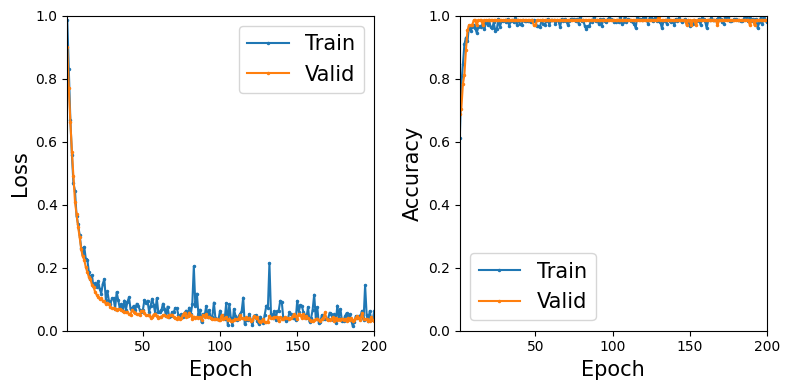

In [54]:
import matplotlib.pyplot as plt
from numpy import linspace


quantities = ["loss", "accuracy"]
splits = ["train", "valid"]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for axis, quant in zip(axes.ravel(), quantities):
    for split in splits:
        key = f"{quant}_{split}"
        axis.plot(
            linspace(1, epochs, epochs),
            metrics[key],
            "-o",
            ms=1.5,
            label=split.capitalize(),
        )
    axis.set_ylabel(quant.capitalize(), fontsize=15)

for axis in axes.ravel():
    axis.legend(fontsize=15)
    axis.set_ylim(bottom=0.0, top=1.0)
    axis.set_xlim(left=1, right=epochs)
    axis.set_xlabel("Epoch", fontsize=15)

fig.tight_layout()

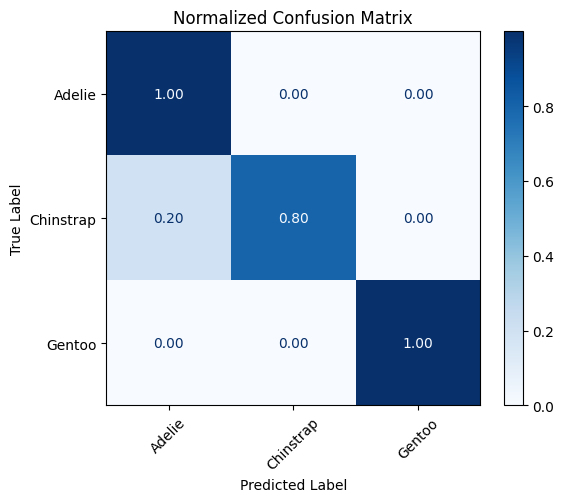

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

class_names = sorted(data.species.unique())

all_preds = []
all_labels = []

model.eval()
with no_grad():
    for batch, label in valid_loader:
        preds = model(batch).softmax(dim=1)
        all_preds.append(preds.argmax(dim=1).numpy())
        all_labels.append(label.argmax(dim=1).numpy())

# concatenate all predictions and labels
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
cm_normalized = cm.astype("float") / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized, display_labels=class_names
)

# plotting
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
disp.ax_.set_xlabel("Predicted Label")
disp.ax_.set_ylabel("True Label")
plt.xticks(rotation=45)
plt.grid(False)  # cleaner plot
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

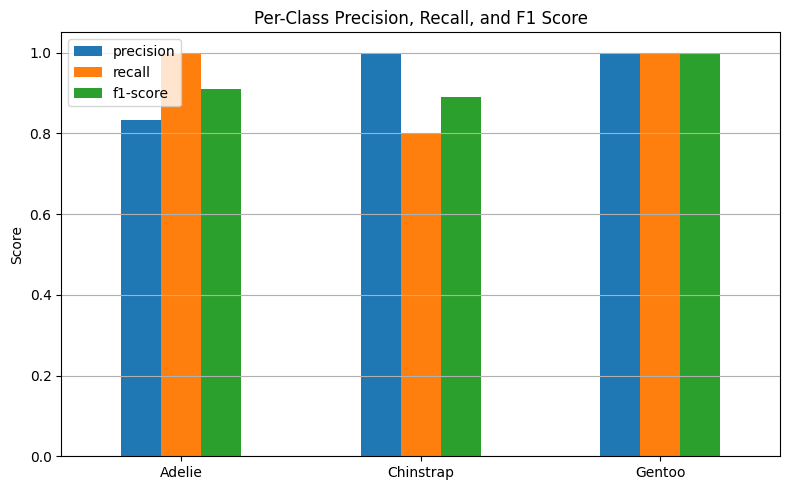

In [48]:
from sklearn.metrics import classification_report
import pandas as pd


# class_names = ['Adelie', 'Chinstrap', 'Gentoo']
report = classification_report(
    y_true=all_labels,
    y_pred=all_preds,
    target_names=class_names,
    output_dict=True  # <- so we can plot it
)


# Convert the report dict to DataFrame for plotting
report_df = pd.DataFrame(report).transpose()
report_df = report_df.loc[class_names, ['precision', 'recall', 'f1-score']]

# Plot
report_df.plot(kind='bar', figsize=(8, 5))
plt.title("Per-Class Precision, Recall, and F1 Score")
plt.ylim(0.0, 1.05)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


### Bonus: Run the net on 'new' inputs

We have built and trained a net, and evaluated and visualised its performance. However, how do we now utilise it going forward?

Here we construct some 'new' input data and use our trained net to infer the species. Whilst this is relatively straightforward there is still some work required to transform the outputs from the net to a meaningful result.

In [55]:
from torch import no_grad

# Construct a tensor of inputs to run the model over
demo_input = tensor(
    [
        [42.9, 13.1, 5000.0, 215.0, 0.0],
        [33.6, 11.3, 2000.0, 211.0, 1.0],
    ]
)
print(f"Raw input:\n{demo_input}\n")

# Place model in eval mode and run over inputs with no_grad
model.eval()
with no_grad():
    demo_output = model(demo_input).softmax(dim=1)

# Print the raw output from the net
print(f"Raw output:\n{demo_output}\n")

# Transform the raw output back to human-readable format
print(f"Predicted species:\n{[target_names[val.argmax()] for val in demo_output]}\n")

Raw input:
tensor([[4.2900e+01, 1.3100e+01, 5.0000e+03, 2.1500e+02, 0.0000e+00],
        [3.3600e+01, 1.1300e+01, 2.0000e+03, 2.1100e+02, 1.0000e+00]])

Raw output:
tensor([[2.7597e-06, 1.7537e-08, 1.0000e+00],
        [5.3855e-01, 5.0576e-06, 4.6145e-01]])

Predicted species:
['Gentoo', 'Adelie']

